# Baseline Model Development

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#import h5py

## Import data

### Flight Data

In [2]:
!ls /home/gridsan/mokeeffe/magnav/flight_data/

Flt1002-magnetometers.csv  Flt1002-train.h5  Flt1004-train.h5
Flt1002-magnetometers.h5   Flt1003-train.h5  Flt1005-train.h5


In [3]:
# Reading hdf files not working on Supercloud using h5py or pandas.read_hdf()
# flight_data = pd.read_hdf("/home/gridsan/mokeeffe/magnav/flight_data/Flt1002-magnetometers.h5", key='df')
flight_data = pd.read_csv("/home/gridsan/mokeeffe/magnav/flight_data/Flt1002-magnetometers.csv")

In [4]:
flight_data.head()

,Unnamed: 0,tt,flux_b_t,flux_b_x,flux_b_y,flux_b_z,flux_c_t,flux_c_x,flux_c_y,flux_c_z,...,flux_d_z,mag_1_c,mag_1_dc,mag_1_igrf,mag_1_lag,mag_1_uc,mag_2_uc,mag_3_uc,mag_4_uc,mag_5_uc
0,0,45100.0,53533.107,28294.945,44045.834,11182.849,54584.776,-48636.719,-23909.552,-6496.585,...,-5872.882,53516.740,53522.679,-297.343,53519.854,53519.161,51888.734,51816.828,52644.111,53644.934
1,1,45100.1,53534.123,28489.807,43945.789,11087.419,54600.732,-48719.451,-23833.611,-6288.771,...,-5662.137,53517.734,53523.780,-296.223,53520.954,53520.123,51875.519,51836.852,52639.238,53650.004
2,2,45100.2,53535.215,28664.771,43859.696,10983.422,54615.024,-48800.914,-23747.780,-6105.427,...,-5477.210,53518.757,53524.904,-295.079,53522.078,53521.114,51858.647,51852.404,52634.938,53656.292
3,3,45100.3,53536.381,28817.314,43788.425,10875.071,54627.602,-48879.150,-23656.250,-5947.409,...,-5319.580,53519.817,53526.025,-293.939,53523.199,53522.145,51838.810,51861.915,52631.027,53662.324
4,4,45100.4,53537.604,28944.894,43732.820,10766.830,54638.511,-48952.235,-23563.447,-5815.530,...,-5189.712,53520.918,53527.123,-292.821,53524.298,53523.217,51818.311,51865.431,52627.730,53666.836


### Preprocessed Data

Let's import the preprocessed magnetometer data, to which we have applied Tolles-Lawson calibration, and corrections for diurnal and core field variations. 

In [5]:
mag_1_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_1_c.csv", header=None, names=["mag_1_TL"])
mag_3_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_3_c.csv", header=None, names=["mag_3_TL"])
mag_5_TL = pd.read_csv("/home/gridsan/mokeeffe/magnav/preprocessed_data/mag_5_c.csv", header=None, names=["mag_5_TL"])

In [6]:
mags_TL = pd.concat([mag_1_TL, mag_3_TL, mag_5_TL], axis=1)
mags_TL.head()

,mag_1_TL,mag_3_TL,mag_5_TL
0,-300.437677,-1033.112280,-49.709221
1,-299.428646,-1028.635159,-45.329437
2,-298.388462,-1026.268370,-39.541183
3,-297.310545,-1028.438106,-34.057425
4,-296.192719,-1034.782676,-30.108781


The min and max indices in MagNav.jl for the calibration 1 line were 12702 and 25002, respectively (note, Julia is 1 indexed and Python is 0 indexed, so we'll subtract 1). Let's plot the three calibrated magnetometers to make sure they look the same as in the first lesson notebook. Even though we just saved from a Julia array into a `.csv` file and loaded into a pandas `DataFrame` here, it's good to check that it worked. 

<Figure size 1152x864 with 0 Axes>

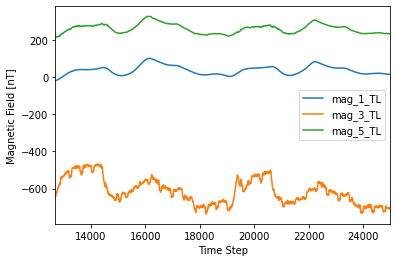

In [7]:
plt.figure(figsize=(16,12))
mags_TL[12701:25001].plot()
plt.xlabel("Time Step")
plt.ylabel("Magnetic Field [nT]")
plt.show()

### Combine the original and processed data into a single dataframe.

In [30]:
df = pd.concat([flight_data, mags_TL], axis=1)

In [31]:
df_test = df.drop(columns=[df.columns[0], 'tt', 'mag_1_dc', 'mag_1_igrf', 'mag_1_lag', 'mag_1_uc', 'mag_2_uc', 'mag_4_uc', 'mag_5_uc', 'mag_1_TL', 'mag_5_TL'], inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207578 entries, 0 to 207577
Data columns (total 15 columns):
flux_b_t    207578 non-null float64
flux_b_x    207578 non-null float64
flux_b_y    207578 non-null float64
flux_b_z    207578 non-null float64
flux_c_t    207578 non-null float64
flux_c_x    207578 non-null float64
flux_c_y    207578 non-null float64
flux_c_z    207578 non-null float64
flux_d_t    207578 non-null float64
flux_d_x    207578 non-null float64
flux_d_y    207578 non-null float64
flux_d_z    207578 non-null float64
mag_1_c     207578 non-null float64
mag_3_uc    207578 non-null float64
mag_3_TL    207578 non-null float64
dtypes: float64(15)
memory usage: 23.8 MB


In [33]:
df.describe()

,flux_b_t,flux_b_x,flux_b_y,flux_b_z,flux_c_t,flux_c_x,flux_c_y,flux_c_z,flux_d_t,flux_d_x,flux_d_y,flux_d_z,mag_1_c,mag_3_uc,mag_3_TL
count,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000
mean,53902.503003,33936.645780,36433.180554,-7940.470046,55484.478818,-51738.290980,-4864.672485,3140.493647,54403.461243,-50792.828797,-2945.356458,1800.903829,53891.706282,53204.619721,-671.268149
std,354.570746,10299.988405,9140.556790,13183.072280,1011.001103,2017.806952,13524.597668,13495.663243,702.096944,1952.797221,13465.011599,13536.232865,351.901850,1086.295525,322.613790
min,52790.187000,-1283.854000,2358.844000,-31327.101000,52302.123000,-55832.763000,-27446.967000,-33265.666000,51550.309000,-54815.479000,-25673.036000,-35399.955000,52778.111000,50570.347000,-5696.744476
25%,53699.357500,24550.546750,30426.759250,-19917.842000,54648.230750,-53098.681250,-19815.260500,-8779.944000,53908.811500,-52056.040250,-17748.535750,-10016.899250,53694.918500,52354.200000,-811.355309
50%,53919.716500,34592.709500,36825.217000,-9037.646000,55565.681000,-51990.962500,-3649.638000,2517.031000,54392.192000,-51018.991000,-1916.112500,1193.546500,53960.924000,53049.811500,-671.341161
75%,54121.831750,42750.603750,44197.064000,6583.804250,56251.962000,-50802.632750,7457.648000,13438.946750,54908.778250,-49981.668250,9335.324000,12169.241250,54094.679750,53914.141000,-527.535651
max,56425.210000,53687.237000,53796.656000,14450.525000,58737.757000,-39722.292000,19517.998000,39847.305000,57193.998000,-38754.350000,21661.084000,38118.542000,56398.514000,56693.904000,3353.002804


<Figure size 1152x864 with 0 Axes>

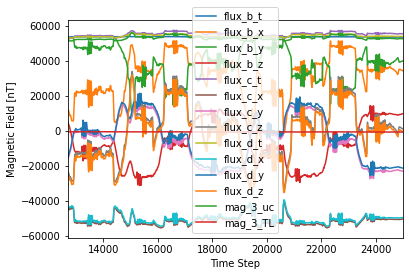

In [25]:
plt.figure(figsize=(16,12))
df[12701:25001].plot()
plt.xlabel("Time Step")
plt.ylabel("Magnetic Field [nT]")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa174572048>,
      dtype=object)

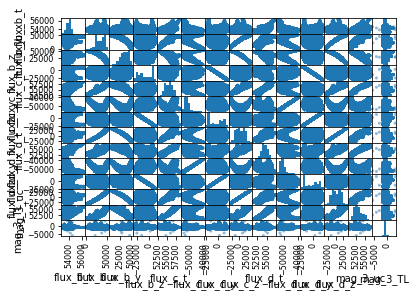

In [27]:
#plt.figure(figsize=(16,12))
#pd.plotting.scatter_matrix(df)
#plt.show()

## Prepare data for model development

Combine the original and processed data into a single dataframe.

In [10]:
target = df.pop('mag_1_c')

In [11]:
N_dev = 30000
dataset = tf.data.Dataset.from_tensor_slices((df.head(N_dev).values, target.head(N_dev).values))
input_shape = dataset.element_spec[0].shape

In [12]:
#for feat, targ in dataset.take(5):
#    print ('Features: {}, Target: {}'.format(feat, targ))

In [13]:
# TODO: normalize or standardize data

In [14]:
# TODO: train/val/test split - 60/20/20

In [15]:
train_dataset = dataset.shuffle(len(df)).batch(32)

In [16]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.Huber(),
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [17]:
model = get_compiled_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_dataset, epochs=30)

Epoch 1/30
938/938 [==============================] - 1s 1ms/step - loss: 971.9500 - mean_squared_error: 17981576.0000 - mean_absolute_error: 972.4495
Epoch 2/30
938/938 [==============================] - 1s 1ms/step - loss: 159.6370 - mean_squared_error: 50581.6133 - mean_absolute_error: 160.1362
Epoch 3/30
938/938 [==============================] - 2s 2ms/step - loss: 155.0996 - mean_squared_error: 41718.0703 - mean_absolute_error: 155.5988
Epoch 4/30
938/938 [==============================] - 2s 2ms/step - loss: 134.0750 - mean_squared_error: 31014.3750 - mean_absolute_error: 134.5741
Epoch 5/30
938/938 [==============================] - 1s 2ms/step - loss: 115.2129 - mean_squared_error: 22583.9277 - mean_absolute_error: 115.7118
Epoch 6/30
938/938 [==============================] - 1s 1ms/step - loss: 107.2666 - mean_squared_error: 19155.7422 - mean_absolute_error: 107.7655
Epoch 7/30
938/938 [==============================] - 1s 1ms/step - loss: 111.3297 - mean_squared_error: 2087

In [19]:
predictions = pd.DataFrame(model.predict(train_dataset))
predictions.head()

,0
0,53717.117188
1,54305.648438
2,53972.960938
3,53874.867188
4,53859.628906


<Figure size 1152x864 with 0 Axes>

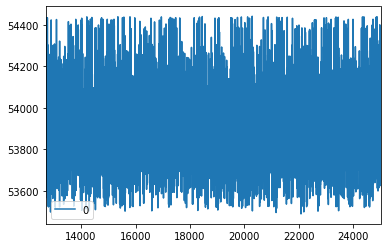

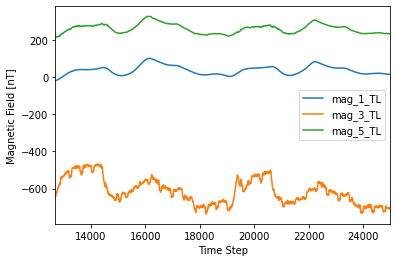

In [20]:
from scipy.signal import detrend
plt.figure(figsize=(16,12))
predictions[12701:25001].plot()
mags_TL[12701:25001].plot()
#plt.plot(detrend(predictions[12701:25001]))
plt.xlabel("Time Step")
plt.ylabel("Magnetic Field [nT]")
plt.show()